In [ ]:
!pip install transformers
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/sequences/sequences2')

In [ ]:
import dataset_flickr7k
import helper_classes as helper
import nltk
nltk.download('punkt')
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils import data as data
import model
import time 
import torch
import torch.nn as nn
import torch.optim as optim
import pathlib
import os 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
CHECKPOINT_DIRECTORY = "model_checkpoints"

# Load Dataset

## Train set 

In [ ]:
# dataset
data_args = {'stage': 'train',
            'ds_path' : "/content/drive/MyDrive/Colab Notebooks/sequences/sequences2", 
            'captions_dir': "",
            'captions_fname': 'results_new.csv',
            'images_dir': '/images_split',
            'freq_threshold': 5}
#train_data = dataset_flickr.Flickr30kData(**data_args)
train_data = dataset_flickr7k.Flickr7kData(**data_args)

print(f"Initialized {len(train_data)} images!") 

length = 7000
stage:  train
ds_path:  /content/drive/MyDrive/Colab Notebooks/sequences/sequences2
captions_f:  /content/drive/MyDrive/Colab Notebooks/sequences/sequences2/results_new.csv
imgs_dir:  /content/drive/MyDrive/Colab Notebooks/sequences/sequences2/images_split/train
Initialized 7736 words in vocabulary
Initialized 35000 images!


## Validation set

In [ ]:
# dataset
data_args = {'stage': 'val',
            'ds_path' : "/content/drive/MyDrive/Colab Notebooks/sequences/sequences2", 
            'captions_dir': "",
            'captions_fname': 'results_new.csv',
            'images_dir': '/images_split',
            'freq_threshold': 5}
#val_data = dataset_flickr.Flickr30kData(**data_args)
val_data = dataset_flickr7k.Flickr7kData(**data_args)

print(f"Initialized {len(val_data)} images!") 

length = 1000
stage:  val
ds_path:  /content/drive/MyDrive/Colab Notebooks/sequences/sequences2
captions_f:  /content/drive/MyDrive/Colab Notebooks/sequences/sequences2/results_new.csv
imgs_dir:  /content/drive/MyDrive/Colab Notebooks/sequences/sequences2/images_split/val
Initialized 7736 words in vocabulary
Initialized 5000 images!


## Set up data loader

In [ ]:
pad_idx = train_data.vocabulary.str_to_idx["<PAD>"]
batch_size = 128 

train_loader = DataLoader(
        dataset=train_data,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=helper.CollateCustom(pad_idx, batch_first=False),
    )


val_loader = DataLoader (
        dataset=val_data,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=helper.CollateCustom(pad_idx, batch_first=False),
    )

# Set up hyperparameters

In [ ]:
# Hyperparameters
embed_size = 256
hidden_size = 256
vocab_size = len(train_data.vocabulary) 
num_layers = 1
learning_rate = 3e-4

# Don't train CNN from scratch
# Tune last layer 
extract_features = True

# Initialize Model, Loss & optimizer

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
import importlib 
import model
importlib.reload(model)
model = model.EncodertoDecoder(embed_size, hidden_size, num_layers, vocab_size, extract_features).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=train_data.vocabulary.str_to_idx["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

Initialized Encoder!
Initialized Decoder!


# Train model

In [ ]:
CHECKPOINT_DIRECTORY = "model_checkpoints"

model.train()

start = 1
num_epochs = 50  
losses = [] 
losses_val = []

time_start = time.time() 

restore_latest_checkpoint = False

if restore_latest_checkpoint:
    #find last checkpoint file based on last modified 
    all_files = pathlib.Path(CHECKPOINT_DIRECTORY).glob('*.pth')
    latest_file = max(all_files, key=os.path.getctime)
    checkpoint_file = str(latest_file).split("/")[1]
    
    #adjust epoch range
    start = int(checkpoint_file.split("_")[2]) + 1 
    num_epochs += start 
    
    #load checkpoint 
    helper.load_checkpoint(checkpoint_file, model, optimizer)

  
"""
Training
"""
# Early stopping variables
previous_loss = 50
triggered = 0

for epoch in range(start, num_epochs+1):
    model.train()

    batch_loss = 0 
    avg_batch_loss = 0 

    for batch_num, (idx, X, y) in enumerate(train_loader):
        X = X.to(device)
        y = y.to(device)

        outputs = model(X, y[:-1])
        
        loss = criterion(
            outputs.reshape(-1, outputs.shape[2]), y.reshape(-1)
        )

        optimizer.zero_grad()
        loss.backward(loss)
        optimizer.step()
        
        batch_loss += loss.item()

    avg_batch_loss = batch_loss/(batch_num+1)
                
    """
    Validation
    """
    # run validation set to see find loss 
    batch_loss_val = 0 
    avg_batch_loss_val = 0 
    with torch.no_grad(): 
        for batch_num_val, (idx_val, X_val, y_val) in enumerate(val_loader):
            X_val = X_val.to(device)
            y_val = y_val.to(device)


            #calculate loss
            out_val = model(X_val, y_val[:-1])
            loss_val = criterion(out_val.reshape(-1, out_val.shape[2]), y_val.reshape(-1))
            
            batch_loss_val += loss_val.item()


    avg_batch_loss_val = batch_loss_val/(batch_num_val+1)

    # save loss after every epoch
    losses.append([avg_batch_loss, avg_batch_loss_val])

    print(f"Training loss after {epoch} epochs: {avg_batch_loss}")
    print(f'Validation loss after {epoch} epochs: {avg_batch_loss_val}')
        
    """
    Save checkpoints
    """ 
    if epoch%5 == 0:
        print("Time elapsed: {} min".format((round((time.time()-time_start)/60, 2))))
        checkpoint = {"state_dict": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "step": epoch
                    }
        fname = "basic_model_" + str(epoch) + "_epochs.pth" 
        helper.save_checkpoint(checkpoint, fname)


    """    
    Early stopping
    """
    current_loss = avg_batch_loss_val

    if current_loss > previous_loss:
        triggered += 1
        print('Early Stopping Trigger Count: ', triggered)

        if triggered >= 3:
            helper.save_model(model.state_dict(), "basic_model.pth")
            print('Early Stopping!')
            break;

    previous_loss = current_loss
    
    #for final epoch 
    if epoch == num_epochs: 
        helper.save_model(model.state_dict(), "basic_model.pth")
             
print("Time elapsed for {} epochs: {} min".format(epoch, 
                                                  round((time.time()-time_start)/60, 2)))
print("loss: ", loss.item())

Training loss after 1 epochs: 5.069717010442358
Validation loss after 1 epochs: 4.2358744740486145
Training loss after 2 epochs: 4.033274424337122
Validation loss after 2 epochs: 3.8866232693195344
Training loss after 3 epochs: 3.780430215988716
Validation loss after 3 epochs: 3.7186895191669462
Training loss after 4 epochs: 3.6347027173007493
Validation loss after 4 epochs: 3.6140151262283324
Training loss after 5 epochs: 3.5332849834957263
Validation loss after 5 epochs: 3.5293256878852843
Time elapsed: 44.28 min
Saved checkpoint basic_model_5_epochs.pth!
Training loss after 6 epochs: 3.4547478969949874
Validation loss after 6 epochs: 3.4625115275382994
Training loss after 7 epochs: 3.3921400726276594
Validation loss after 7 epochs: 3.401897531747818
Training loss after 8 epochs: 3.338527788210959
Validation loss after 8 epochs: 3.378603905439377
Training loss after 9 epochs: 3.2896466481424596
Validation loss after 9 epochs: 3.348192298412323
Training loss after 10 epochs: 3.2461862

## Plot loss 

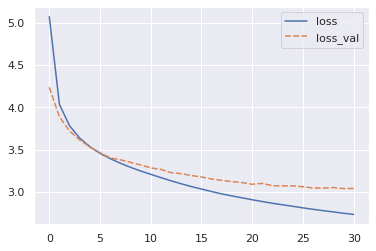

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd
sns.set() 


if restore_latest_checkpoint: 
    #add to existing losses 
    old_losses = pd.read_csv('loss.csv')[["epochs", "loss", "loss_val"]]
    start_index = old_losses.epochs.max() + 1
    new_data = [[start_index+i, losses[i][0], losses[i][1]] for i in range(len(losses))]
    new_losses = pd.DataFrame(new_data, columns = ["epochs", "loss", "loss_val"])
    loss_df = pd.concat([old_losses, new_losses], keys = ["epochs", "loss", "loss_val"]).reset_index(drop = True)
    
else:
    #create new df 
    loss_df = pd.DataFrame(losses, columns = ['loss', "loss_val"])
    loss_df = loss_df.reset_index().rename(columns= {'index': 'epochs'})
    
loss_df.to_csv("loss.csv")

loss_df
sns.lineplot(data= loss_df.iloc[:, 1:])